### Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=1e5a7338b917d0f9d50a60ca931972747cc22ecbbc8af95409c2ac49a09d4f73
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import os
import ta
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from sklearn.decomposition import PCA


#### Code to get data for nadsaq and its technical indicators

In [ ]:
# # Load or fetch NASDAQ data
# if os.path.exists("nasdaq.csv"):
#     nasdaq = pd.read_csv("nasdaq.csv")
# else:
#     nasdaq = yf.Ticker("^IXIC")
#     nasdaq = nasdaq.history(period="max")
#     nasdaq.to_csv("nasdaq.csv")

# #Technical indicators
# # Calculate technical indicators
# print("Calculating technical indicators...")
# nasdaq['EMA_50'] = ta.trend.ema_indicator(nasdaq['Close'], window=50)
# nasdaq['EMA_200'] = ta.trend.ema_indicator(nasdaq['Close'], window=200)
# nasdaq['RSI'] = ta.momentum.rsi(nasdaq['Close'])
# macd = ta.trend.MACD(nasdaq['Close'])
# nasdaq['MACD'] = macd.macd()
# nasdaq['MACD_Signal'] = macd.macd_signal()
# nasdaq['MACD_Hist'] = macd.macd_diff()

# # Filter the data starting from 1990-01-01
# nasdaq['Date'] = pd.to_datetime(nasdaq['Date'], utc=True)

# nasdaq = nasdaq[nasdaq['Date'] > '1990-01-01']

# #Removing the unwanted columns
# # del nasdaq['Dividends']
# # del nasdaq['Stock Splits']

# #save the latest file
# nasdaq.to_csv("nasdaq.csv")

Calculating technical indicators...


In [3]:
# Load the dataset
file_path = 'nasdaq.csv'
nasdaq_data = pd.read_csv(file_path)

In [4]:
nasdaq_data.head()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,EMA_50,EMA_200,RSI,MACD,MACD_Signal,MACD_Hist
0,4776,1990-01-02 05:00:00+00:00,452.899994,459.299988,452.700012,459.299988,110720000,453.490768,444.839773,62.885333,-1.049759,-2.890670,1.840911
1,4777,1990-01-03 05:00:00+00:00,461.100006,461.600006,460.000000,460.899994,152660000,453.781326,444.999576,64.551665,-0.049565,-2.322449,2.272884
2,4778,1990-01-04 05:00:00+00:00,460.399994,460.799988,456.899994,459.399994,147950000,454.001666,445.142864,61.752523,0.614970,-1.734965,2.349935
3,4779,1990-01-05 05:00:00+00:00,457.899994,459.399994,457.799988,458.200012,137230000,454.166307,445.272785,59.528642,1.032884,-1.181395,2.214279
4,4780,1990-01-08 05:00:00+00:00,457.100006,458.700012,456.500000,458.700012,115500000,454.344100,445.406390,60.172252,1.388424,-0.667432,2.055856


In [5]:
nasdaq_data.tail()

,Unnamed: 0,Date,Open,High,Low,Close,Volume,EMA_50,EMA_200,RSI,MACD,MACD_Signal,MACD_Hist
8693,13469,2024-07-08 04:00:00+00:00,18371.859375,18416.939453,18342.599609,18403.740234,5286260000,17189.750516,15675.307967,76.595822,346.377771,314.919227,31.458543
8694,13470,2024-07-09 04:00:00+00:00,18465.019531,18511.890625,18381.599609,18429.289062,4839140000,17238.359870,15702.710764,76.984401,357.604954,323.456373,34.148581
8695,13471,2024-07-10 04:00:00+00:00,18512.089844,18655.189453,18467.580078,18647.449219,5228240000,17293.618276,15732.011644,80.032922,379.729000,334.710898,45.018102
8696,13472,2024-07-11 04:00:00+00:00,18659.250000,18671.070312,18238.779297,18283.410156,6366620000,17332.433644,15757.398694,64.645599,363.695104,340.507739,23.187365
8697,13473,2024-07-12 04:00:00+00:00,18303.640625,18556.730469,18293.599609,18398.449219,5845930000,17374.238176,15783.677803,66.816775,356.165167,343.639225,12.525943


In [6]:
# Drop the unnecessary columns
df = nasdaq_data.drop(columns=['Unnamed: 0', 'Date', 'Volume', 'Open', 'High',	'Low'	])


In [7]:
df.head(15)

,Close,EMA_50,EMA_200,RSI,MACD,MACD_Signal,MACD_Hist
0,459.299988,453.490768,444.839773,62.885333,-1.049759,-2.890670,1.840911
1,460.899994,453.781326,444.999576,64.551665,-0.049565,-2.322449,2.272884
2,459.399994,454.001666,445.142864,61.752523,0.614970,-1.734965,2.349935
3,458.200012,454.166307,445.272785,59.528642,1.032884,-1.181395,2.214279
4,458.700012,454.344100,445.406390,60.172252,1.388424,-0.667432,2.055856
5,456.799988,454.440409,445.519759,56.495515,1.499590,-0.234027,1.733617
6,450.700012,454.293727,445.571304,46.641888,1.082989,0.029376,1.053613
7,448.899994,454.082208,445.604425,44.192465,0.600659,0.143633,0.457026
8,439.700012,453.518200,445.545674,34.282804,-0.517982,0.011310,-0.529291
9,436.600006,452.854741,445.456663,31.703085,-1.635800,-0.318112,-1.317688


In [ ]:
# Use all columns except 'Close' as features for X
features = df.columns.tolist()
# features = ['EMA_50', 'EMA_200', 'RSI', 'MACD', 'MACD_Signal', 'MACD_Hist']
features.remove('Close')

# Prepare X and Y
X = df[features].values
Y = df['Close'].values



In [ ]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler
# Normalize the dataset
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_Y = MinMaxScaler(feature_range=(0, 1))

X_scaled = scaler_X.fit_transform(X)
Y_scaled = scaler_Y.fit_transform(Y.reshape(-1, 1))


In [ ]:
# Create sequences (lookback period)
lookback = 60
X_seq = []
Y_seq = []

for i in range(lookback, len(X_scaled)):
    X_seq.append(X_scaled[i-lookback:i])
    Y_seq.append(Y_scaled[i])

X_seq, Y_seq = np.array(X_seq), np.array(Y_seq)

# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_seq, Y_seq, test_size=0.2, random_state=42)

#### Model Stacked LSTM for price prediction

In [ ]:
# Define the LSTM model
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predicting the 'Close' price

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, Y_train, epochs=100, batch_size=16, validation_data=(X_test, Y_test), verbose=1, callbacks=[early_stopping])

# Evaluate the model
loss = model.evaluate(X_test, Y_test, verbose=1)
print(f'Test Loss: {loss}')


Epoch 1/100
432/432 [==============================] - 42s 98ms/step - loss: 5.5012e-04 - val_loss: 2.3994e-04
Epoch 2/100
432/432 [==============================] - 39s 91ms/step - loss: 3.9406e-04 - val_loss: 1.1486e-04
Epoch 3/100
432/432 [==============================] - 42s 98ms/step - loss: 3.4754e-04 - val_loss: 6.9789e-05
Epoch 4/100
432/432 [==============================] - 37s 86ms/step - loss: 2.9412e-04 - val_loss: 8.0570e-05
Epoch 5/100
432/432 [==============================] - 39s 90ms/step - loss: 3.4581e-04 - val_loss: 1.4984e-04
Epoch 6/100
432/432 [==============================] - 39s 91ms/step - loss: 3.1677e-04 - val_loss: 1.2494e-04
Epoch 7/100
432/432 [==============================] - 39s 90ms/step - loss: 3.0429e-04 - val_loss: 4.7986e-05
Epoch 8/100
432/432 [==============================] - 39s 91ms/step - loss: 3.1524e-04 - val_loss: 4.1706e-05
Epoch 9/100
432/432 [==============================] - 39s 91ms/step - loss: 2.9367e-04 - val_loss: 7.8643e-05
E

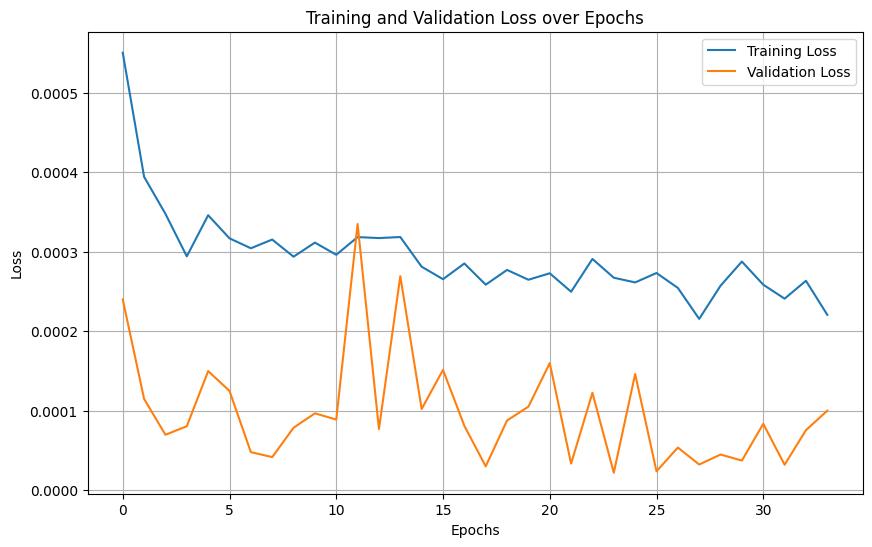

In [ ]:
# Plotting training & validation loss values
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()

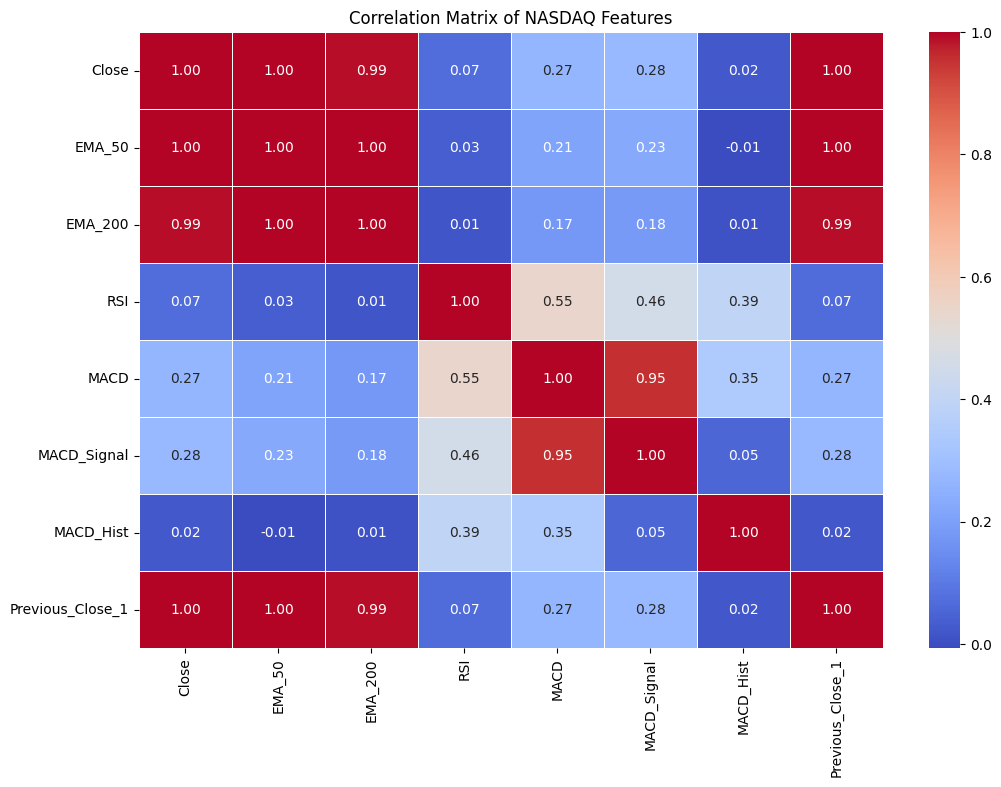

In [ ]:
import seaborn as sns
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Correlation Matrix of NASDAQ Features')
plt.show()

In [ ]:
X_train.shape[1], X_train.shape[2]

(60, 6)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Make predictions
Y_pred_scaled = model.predict(X_test)

# Inverse transform the predictions and actual values
Y_pred = scaler_Y.inverse_transform(Y_pred_scaled)
Y_actual = scaler_Y.inverse_transform(Y_test)

# Calculate MSE and RMSE
mse = mean_squared_error(Y_actual, Y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(Y_actual, Y_pred)
r2 = r2_score(Y_actual,Y_pred)

print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'R2 Score: {r2}')


54/54 [==============================] - 2s 36ms/step
MSE: 7414.066531199037
RMSE: 86.1049739051063
MAE: 51.17316731700192
R2 Score: 0.9995654903099653


In [ ]:
# Define a threshold for a prediction to be considered 'true'
threshold = 0.02  # for example, 2%

# Calculate the absolute percent error for each prediction
errors = np.abs((Y_pred - Y_actual) / Y_actual)

# Count the number of 'true' predictions
num_true_predictions = np.sum(errors < threshold)

# Calculate the accuracy
accuracy = num_true_predictions / len(Y_pred)

print(f'Accuracy: {accuracy}')


Accuracy: 0.7025462962962963


In [ ]:
# Generate predictions for the next 30 days
future_predictions = []
last_sequence = X_scaled[-lookback:]

for _ in range(30):
    # Make prediction
    next_prediction_scaled = model.predict(last_sequence.reshape(1, lookback, -1))
    next_prediction = scaler_Y.inverse_transform(next_prediction_scaled)
    future_predictions.append(next_prediction[0][0])

    # Update the sequence by appending the prediction and removing the oldest entry
    next_prediction_features = np.append(last_sequence[-1, :-1], next_prediction_scaled).reshape(1, -1)
    last_sequence = np.append(last_sequence[1:], next_prediction_features, axis=0)

# Prepare dates for plotting future predictions
last_date = pd.to_datetime(nasdaq_data['Date'].iloc[-1])
future_dates = [last_date + pd.DateOffset(days=i) for i in range(1, 31)]

1/1 [==============================] - 0s 44ms/step


In [ ]:
# Print next 30 days prices with dates
for date, price in zip(future_dates, future_predictions):
    print(f'Date: {date}, Predicted Close Price: {price}')

Date: 2024-07-13 04:00:00+00:00, Predicted Close Price: 18118.953125
Date: 2024-07-14 04:00:00+00:00, Predicted Close Price: 18949.75
Date: 2024-07-15 04:00:00+00:00, Predicted Close Price: 19108.966796875
Date: 2024-07-16 04:00:00+00:00, Predicted Close Price: 18954.34375
Date: 2024-07-17 04:00:00+00:00, Predicted Close Price: 18817.9296875
Date: 2024-07-18 04:00:00+00:00, Predicted Close Price: 18759.876953125
Date: 2024-07-19 04:00:00+00:00, Predicted Close Price: 18744.75390625
Date: 2024-07-20 04:00:00+00:00, Predicted Close Price: 18739.240234375
Date: 2024-07-21 04:00:00+00:00, Predicted Close Price: 18729.478515625
Date: 2024-07-22 04:00:00+00:00, Predicted Close Price: 18714.3984375
Date: 2024-07-23 04:00:00+00:00, Predicted Close Price: 18696.46875
Date: 2024-07-24 04:00:00+00:00, Predicted Close Price: 18677.740234375
Date: 2024-07-25 04:00:00+00:00, Predicted Close Price: 18659.134765625
Date: 2024-07-26 04:00:00+00:00, Predicted Close Price: 18640.923828125
Date: 2024-07-2

In [ ]:
Y_actual.shape, Y_pred.shape

((1728, 1), (1728, 1))

In [ ]:
Y_actual, Y_pred

(array([[  886.13000488],
        [14141.48046875],
        [ 2406.09008789],
        ...,
        [  435.        ],
        [ 7066.27001953],
        [ 1909.47998047]]),
 array([[  852.61304],
        [14112.594  ],
        [ 2454.7283 ],
        ...,
        [  417.9458 ],
        [ 7128.7837 ],
        [ 1860.1444 ]], dtype=float32))

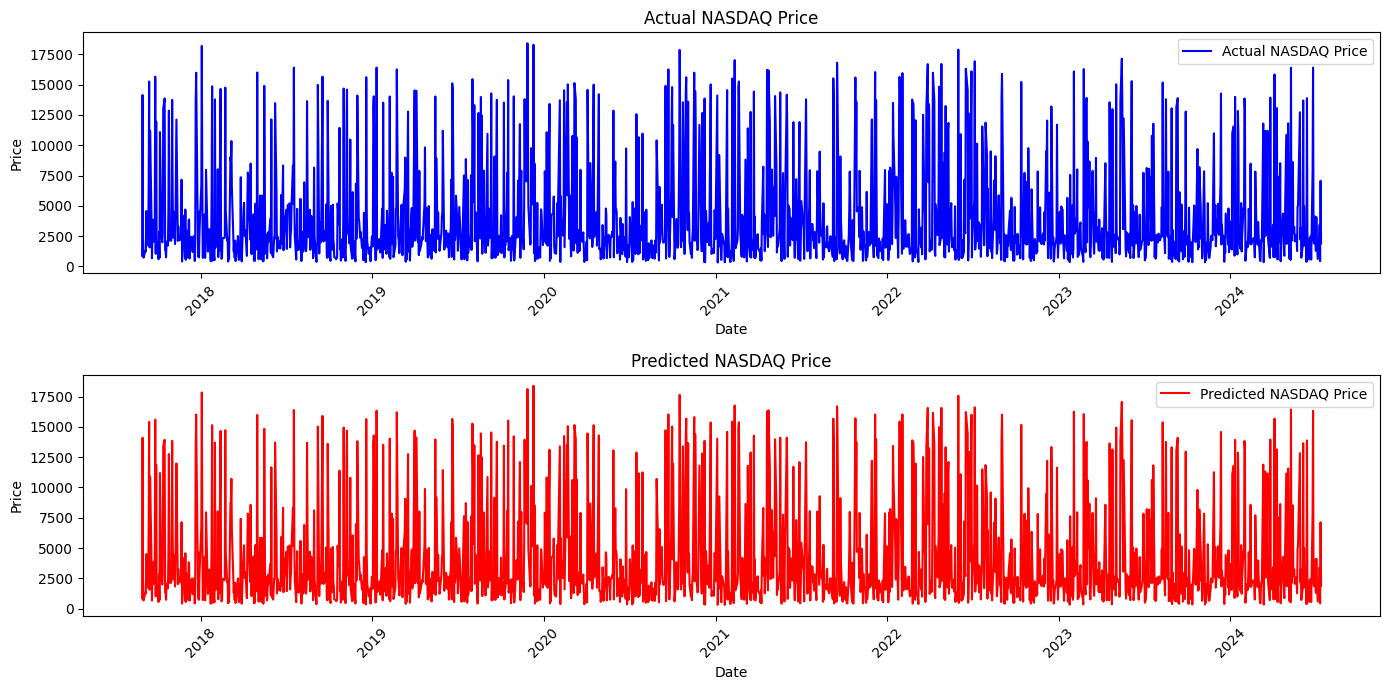

In [ ]:
full_dates = pd.to_datetime(nasdaq_data['Date'])

# Plot actual and predicted values
plt.figure(figsize=(14, 7))

# Subplot 1: Actual values
plt.subplot(2, 1, 1)
plt.plot(full_dates[-len(Y_actual):], Y_actual, color='blue', label='Actual NASDAQ Price')
plt.title('Actual NASDAQ Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

# Subplot 2: Predicted values
plt.subplot(2, 1, 2)
plt.plot(full_dates[-len(Y_pred):], Y_pred, color='red', label='Predicted NASDAQ Price')
plt.title('Predicted NASDAQ Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

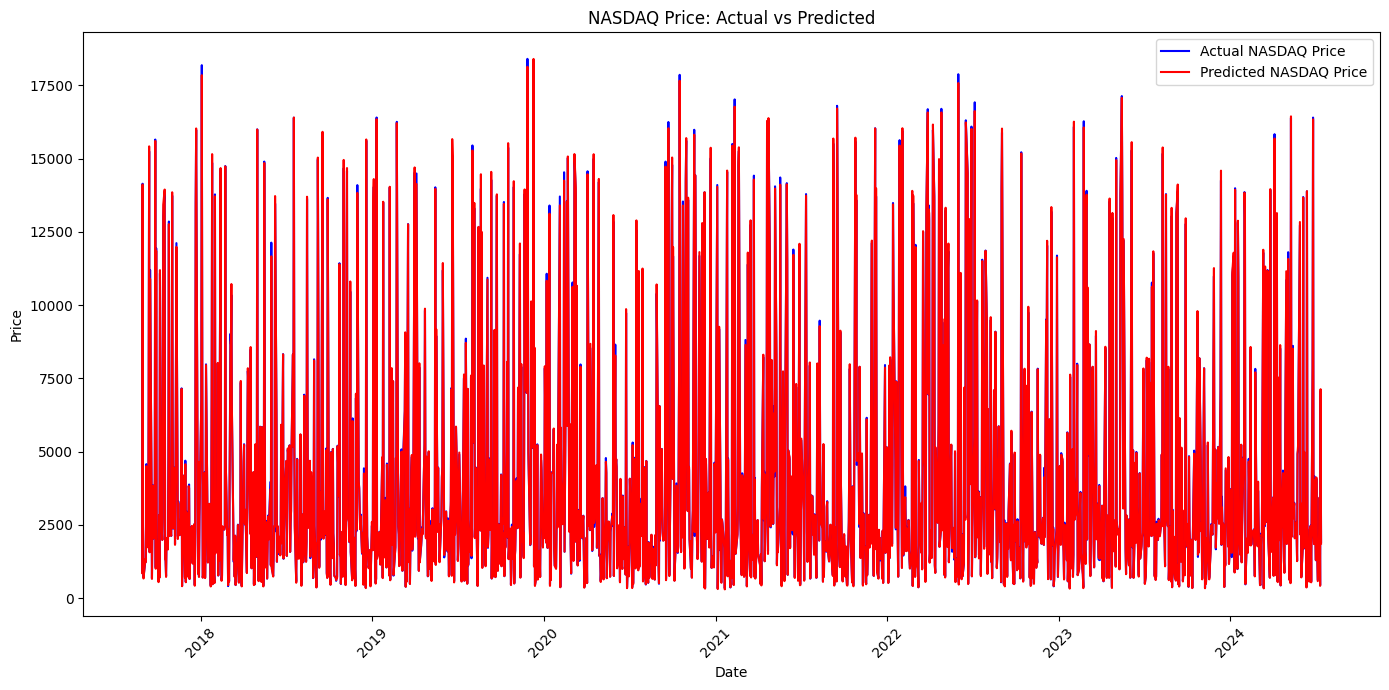

In [ ]:
import matplotlib.pyplot as plt

# Create a figure
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(full_dates[-len(Y_actual):], Y_actual, color='blue', label='Actual NASDAQ Price')

# Plot predicted values
plt.plot(full_dates[-len(Y_pred):], Y_pred, color='red', label='Predicted NASDAQ Price')

# Set title, labels and legend
plt.title('NASDAQ Price: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Rotate x-axis labels
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()
plt.show()


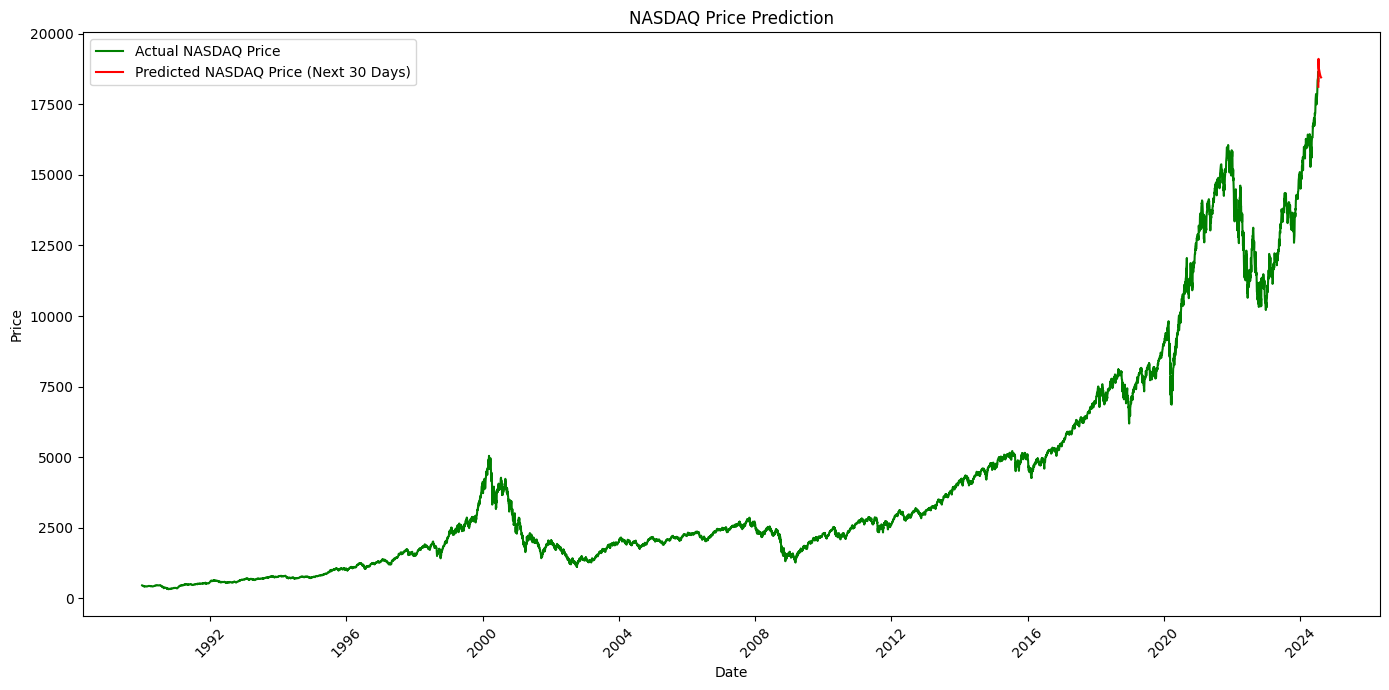

In [ ]:
# Plot actual and predicted values
plt.figure(figsize=(14, 7))
plt.plot(full_dates[-len(Y_scaled):], scaler_Y.inverse_transform(Y_scaled).flatten(), color='green', label='Actual NASDAQ Price')
plt.plot(future_dates, future_predictions, color='red', label='Predicted NASDAQ Price (Next 30 Days)')
plt.title('NASDAQ Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


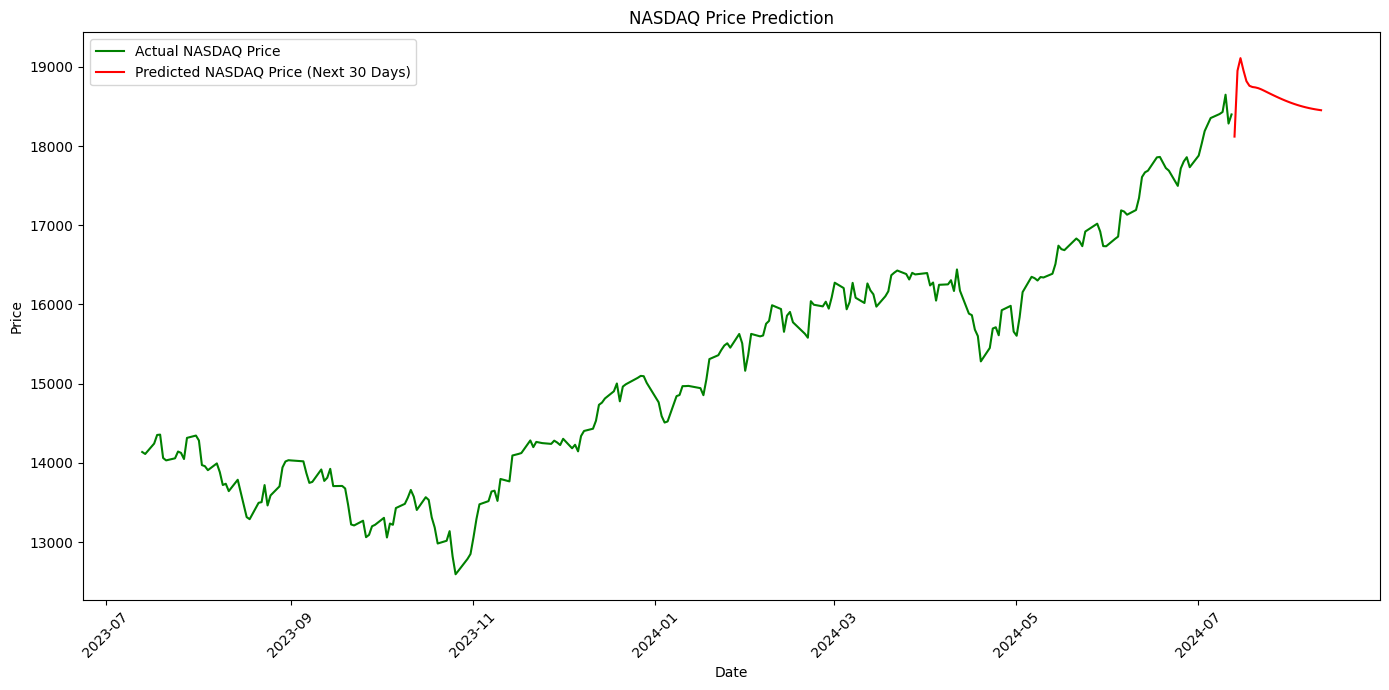

In [ ]:
# Calculate the number of trading days in a year (usually around 252)
trading_days_in_a_year = 252

# Select the data for the last one year
last_year_dates = full_dates[-trading_days_in_a_year:]
last_year_prices = scaler_Y.inverse_transform(Y_scaled[-trading_days_in_a_year:]).flatten()

# Plot actual and predicted values
plt.figure(figsize=(14, 7))
plt.plot(last_year_dates, last_year_prices, color='green', label='Actual NASDAQ Price')
plt.plot(future_dates, future_predictions, color='red', label='Predicted NASDAQ Price (Next 30 Days)')
plt.title('NASDAQ Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
